In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.formula.api import ols

import geopandas as gpd

In [71]:
properties = pd.read_csv("../data/curated/properties_processed.csv", index_col=0)
income = pd.read_csv("../data/raw/external/vic_income.csv", index_col=0)
mapping = pd.read_csv("../data/raw/external/sa2_postcode_map.csv", index_col=0)

In [72]:
properties['Postcode'] = properties['Postcode'].astype(str)

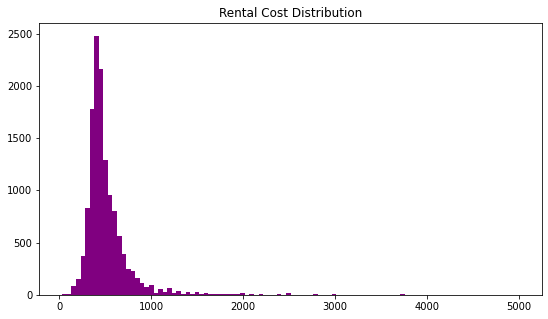

In [63]:
# Rental Cost Distribution
plt.figure(figsize = (9, 5))
plt.title('Rental Cost Distribution')
plt.hist(properties['Cost'], bins=100, color='purple')
plt.savefig('../plots/cost_distribution.jpg')
plt.show()

In [73]:
mapping['POSTCODE'] = mapping['POSTCODE'].astype(str)

In [74]:
properties = pd.merge(properties, mapping, left_on='Postcode', right_on='POSTCODE').drop('POSTCODE', axis=1)

In [80]:
properties['SA2_MAINCODE_2011'] = properties['SA2_MAINCODE_2011'].astype(str)
properties = properties.rename({'SA2_MAINCODE_2011':'SA2'})

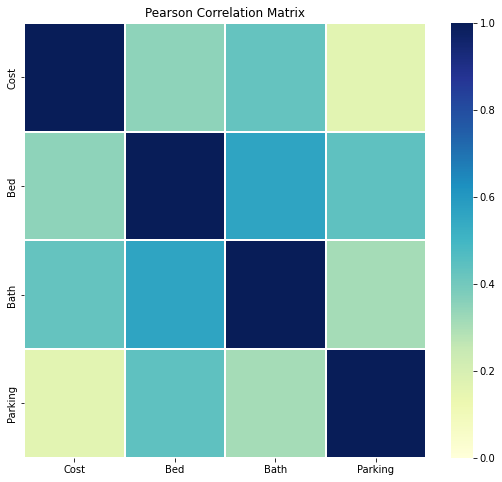

In [77]:
# get correlation of numeric attributes with cost
corrmat = properties.corr()
f, ax = plt.subplots(figsize =(9, 8))
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1, vmin=0)

plt.title('Pearson Correlation Matrix')
plt.savefig('../plots/correlation.jpg')
plt.show()

In [81]:
# test for relationship with categorical variables using one-way ANOVA
categoricals = ['Postcode', 'Property_Type', 'Agency']

for c in categoricals:
    model = ols('Cost ~ '+c, data = properties).fit() # Oridnary least squares
    result_anova = sm.stats.anova_lm(model) # ANOVA Test
    print(result_anova)

               df        sum_sq        mean_sq         F  PR(>F)
Postcode    408.0  2.143759e+08  525431.170857  9.528609     0.0
Residual  12814.0  7.065958e+08   55142.484002       NaN     NaN
                    df        sum_sq       mean_sq          F        PR(>F)
Property_Type     13.0  3.323701e+07  2.556693e+06  38.042171  1.578068e-95
Residual       13209.0  8.877347e+08  6.720681e+04        NaN           NaN
               df        sum_sq        mean_sq         F  PR(>F)
Agency     1385.0  3.449491e+08  249060.727395  5.118084     0.0
Residual  11837.0  5.760226e+08   48662.887579       NaN     NaN


All p values are less than 0.05 so all attributes are significant.

## Income Data

In [8]:
income['SA2'] = income['SA2'].astype(str)
income.head()

,SA2,SA2_name,Earners,Median_age,Sum,Median
579,201011001,Alfredton,7989,42,508645842,53932
580,201011002,Ballarat,7595,47,591465895,53688
581,201011003,Ballarat - North,13598,43,820866354,50593
582,201011004,Ballarat - South,12722,40,646001740,45828
583,201011005,Buninyong,4249,46,268782250,52377


In [9]:
# read in shapefile and merge with SA2
sf = gpd.read_file('../data/raw/external/SA2_shapefile/SA2_2016_AUST.shp')
print(sf.head())
gdf = gpd.GeoDataFrame(
    pd.merge(income, sf, left_on='SA2', right_on='SA2_MAIN16', how='inner')
)
geoJSON = gdf[['SA2', 'geometry']].to_json()

  SA2_MAIN16 SA2_5DIG16         SA2_NAME16 SA3_CODE16  SA3_NAME16 SA4_CODE16  \
0  101021007      11007          Braidwood      10102  Queanbeyan        101   
1  101021008      11008            Karabar      10102  Queanbeyan        101   
2  101021009      11009         Queanbeyan      10102  Queanbeyan        101   
3  101021010      11010  Queanbeyan - East      10102  Queanbeyan        101   
4  101021011      11011  Queanbeyan Region      10102  Queanbeyan        101   

       SA4_NAME16 GCC_CODE16   GCC_NAME16 STE_CODE16       STE_NAME16  \
0  Capital Region      1RNSW  Rest of NSW          1  New South Wales   
1  Capital Region      1RNSW  Rest of NSW          1  New South Wales   
2  Capital Region      1RNSW  Rest of NSW          1  New South Wales   
3  Capital Region      1RNSW  Rest of NSW          1  New South Wales   
4  Capital Region      1RNSW  Rest of NSW          1  New South Wales   

   AREASQKM16                                           geometry  
0   3418.3525